In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# with open("/content/drive/MyDrive/covid/data/new_york_(excludes_nyc).csv", "r", encoding="utf-8") as f:
#     data = f.read()

# data = [row.split(',') for row in  data.split("\n")]

# # value = [int(each[1]) for each in data]
# value = [float(each[2]) for each in data[1:]]

import csv
value = []
with open("cleaned/new_ny.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        value.append(int(i[2]))

value.reverse()

train  = value[:-200]
test = value[-200:]


# 设置序列数据的时间跨度，seq=7, 指使用过去七天的数据来预测明天的数据
# 注意，这并不是说LSTM每次都只利用到7天的历史数据进行预测，而是7天的显式数据+所有已输入的数据产生的隐式信息（只是隐式信息具有离当前预测距离越远，信息量越弱的特点，详情看下行链接）
# https://www.jianshu.com/p/6815da2d413d 关于RNN的长距离依赖问题，看下这个链接，LSTM比RNN在这方面强很多，但问题仍然存在。


seq = 7

# 训练集构造

li_x = []
li_y = []

for i in range(len(train) - seq):
    # 输入就是[x, x+1, x+2, ... , x + (seq-1)]天的数据，输出是 x + seq 天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

# 对数据进行缩放有利于训练的收敛，但更好的方式是进行归一化处理；在当前应用上，这几种操作对结果不会造成太大影响，可以作为以后的练习。
# 关于归一化的作用，可以参考这个帖子：https://www.cnblogs.com/LBSer/p/4440590.html

train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)


# 测试集构造

t_x = []
t_y = []

for i in range(len(test) - seq):
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [5]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [20]:
model.train()
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))
        if test_loss < 20:
              # # 保存整个网络
          # torch.save(model, 'demo') 
          # # 保存网络中的参数, 速度快，占空间少
          # torch.save(model.state_dict(),'demo')
          break


epoch:20, loss:0.03441424295306206, test_loss: 28.709373474121094
epoch:40, loss:0.03370898589491844, test_loss: 28.663118362426758
epoch:60, loss:0.033036768436431885, test_loss: 28.611652374267578
epoch:80, loss:0.03303291276097298, test_loss: 28.575336456298828
epoch:100, loss:0.031801048666238785, test_loss: 28.51246452331543
epoch:120, loss:0.031190529465675354, test_loss: 28.46984100341797
epoch:140, loss:0.03060671128332615, test_loss: 28.42377281188965
epoch:160, loss:0.030067432671785355, test_loss: 28.358840942382812
epoch:180, loss:0.029546447098255157, test_loss: 28.33183479309082
epoch:200, loss:0.028988853096961975, test_loss: 28.285249710083008
epoch:220, loss:0.028483854606747627, test_loss: 28.232067108154297
epoch:240, loss:0.028553921729326248, test_loss: 28.200712203979492
epoch:260, loss:0.027594758197665215, test_loss: 28.147567749023438
epoch:280, loss:0.026969337835907936, test_loss: 28.100788116455078
epoch:300, loss:0.027347756549715996, test_loss: 28.04088973

使用正确数据作为输入进行预测

MSE: 28760374.0


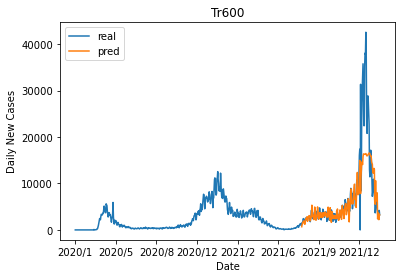

In [7]:
model.eval()

# print(len(value))
# print(len(train))
# print(len(test))
#result = [] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)
test_pre = list((model(test_x).data.reshape(-1))*1000)

from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(test_y*1000, test_pre))



# # 真实数据
# plt.plot(test_y*1000, label="real")

# 真实数据
#plt.figure(figsize=(8,5))
plt.plot(value, label="real")

test_data = [None]*558 + test_pre
#test_data = result

# 预测结果
plt.plot(test_data, label="pred")
#plt.title('Combining Methods of Predictions On New York City')
plt.title('Tr600')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '2021/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')

plt.savefig('fig1.png', dpi = 300)


In [8]:
#Tr 400 19685076.0
#Tr 500 MSE: 19886270.0

In [9]:
from sklearn.metrics import mean_squared_error
temp_MSE = []
temp_RMSE = []
for i in range(600,700,100):
    MSE = mean_squared_error(value[i:i+100], test_data[i:i+100])
    temp_MSE.append(MSE)
    RMSE = MSE ** 0.5
    temp_RMSE.append(RMSE)
print(temp_MSE, sum(temp_MSE)/ 2)
print(temp_RMSE, sum(temp_RMSE) / 2)

[1405813.7610078282] 702906.8805039141
[1185.6701737868875] 592.8350868934438


In [10]:
# [468159.8713281174, 395918.51832596475, 2085784.0638095618]
# [684.222092107612, 629.2205641315013, 1444.2243813928505]

lstm 使用过去seq_len的数据预测明天的数据
lstm(x) = y

min (y_pre, y_real)



假设我们有10个月的数据

train_set 训练模型 （7个月）
data_sample: x1 = [1,2,3,4,5,6,7]  y1 = [8]
             x2 = [2,3,4,5,6,7,8]  y2 = [9]
            ...
             xn = [..., 209] yn = [210]



test_set 测试模型 （3个月）

data_sample: x1 = [210, ...]  y1 = [217]
             x2 = [211,...]  y2 = [218]
             ...
             xn = [..., 299] yn = [300]

performance: MSE(lstm(test_set(x)), y_real)           



使用预测数据作为输入递归预测未来趋势

[tensor(0.7750), tensor(0.9450), tensor(1.1740), tensor(1.2590), tensor(1.3680), tensor(1.2540), tensor(0.9410)]
200
193
[774.9999761581421, 944.9999928474426, 1174.0000247955322, 1258.9999437332153, 1368.0000305175781, 1253.999948501587, 940.9999847412109, 683.0318570137024, 787.2949838638306, 1081.032156944275, 1197.7721452713013, 1147.5142240524292, 1089.7067785263062, 903.897762298584, 696.7571973800659, 801.1592626571655, 1035.7707738876343, 1076.5405893325806, 1078.2233476638794, 1013.9931440353394, 861.7479205131531, 824.5416879653931, 939.4418597221375, 1036.0335111618042, 1071.219563484192, 1048.3423471450806, 973.6412167549133, 919.0524220466614, 959.7195982933044, 1037.4819040298462, 1084.542989730835, 1088.9931917190552, 1055.7957887649536, 1019.203782081604, 1033.7270498275757, 1082.9625129699707, 1129.679799079895, 1150.6181955337524, 1144.3251371383667, 1131.5523386001587, 1140.6471729278564, 1170.4375743865967, 1209.2700004577637, 1238.9317750930786, 1252.4287700653076,

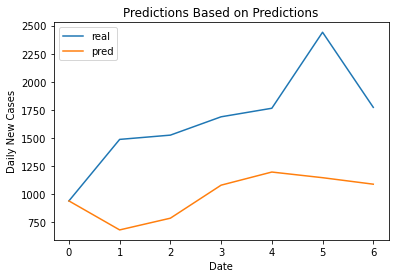

In [19]:
result = []

result.append(test_x[0][0][0])
result.append(test_x[0][1][0])
result.append(test_x[0][2][0])
result.append(test_x[0][3][0])
result.append(test_x[0][4][0])
result.append(test_x[0][5][0])
result.append(test_x[0][6][0])


print(result)
# 预测未来10天的数据，
for i in range(193):
  result.append(model(torch.tensor(result[i:i+7]).reshape(1,7,1)))



print(len(result)) 
print(len(test_y)) 

result = [i.item() * 1000 for i in result]
print(result)

# print("MSE:", mean_squared_error(test_y[0:30]*1000, result[7:]))


# plt.figure(figsize=(10,5))

# 真实数据
plt.plot(value[557:564], label="real")
# plt.plot(value, label="real")
# plt.plot(value[557:564], label="real")
result = [None]*551 + result

# 预测结果
plt.plot(result[557:564], label="pred")
# plt.plot(result, label="pred")
# 模型预测的走势
plt.title('Predictions Based on Predictions')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
# plt.xticks(
#     [0,100,200,300,400,500,600,700],
#     ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '2021/6', '2021/9', '2021/12']
# )
plt.legend(loc='best')
plt.savefig('fig2.png', dpi = 300)

lstm 使用过去seq_len的数据预测明天的数据
lstm(x) = y

min (y_pre, y_real)



假设我们有10个月的数据

train_set 训练模型 （7个月）
data_sample: x1 = [1,2,3,4,5,6,7]  y1 = [8]
             x2 = [2,3,4,5,6,7,8]  y2 = [9]
            ...
             xn = [..., 209] yn = [210]



test_set 测试模型 （3个月）

data_sample: x1 = [210, ...]  y1 = [217]
             x2 = [211,...]  y2 = [218]
             ...
             xn = [..., 299] yn = [300]

performance: MSE(lstm(test_set(x)), y_real)    


真实环境下，预测第11个月的数据：
model = lstm
model([...*6,300]) = y_301
model([...*5, 300, y_301]) = y_302
       ....


预测的越远，效果越差


如果数据有固定的模式，则效果不会变的特别差

黑天鹅




